In [1]:
import torch
from torch import nn 

torch.__version__

'2.3.0'

In [2]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

'mps'

# Get dataset from github

In [1]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print("Directory exists!")
else:
    image_path.mkdir(parents=True,exist_ok=True)
    print("Directory created!")

with open(data_path / "pizza_steak_sushi.zip", "wb") as f: 
    request = requests.get(
    "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip"
    )
    print("Donwloading data")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip") as zip_ref:
    zip_ref.extractall(image_path)

Directory created!
Donwloading data


# convert data

In [4]:
import os 

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)}, directories and {len(filenames)} images in {dirpath}"
        )

In [5]:
walk_through_dir(image_path)

There are 2, directories and 0 images in data/pizza_steak_sushi
There are 3, directories and 0 images in data/pizza_steak_sushi/test
There are 0, directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0, directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0, directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3, directories and 0 images in data/pizza_steak_sushi/train
There are 0, directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0, directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0, directories and 78 images in data/pizza_steak_sushi/train/pizza


In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### pillow -> python image processing lib

In [17]:
import random 
from PIL import Image

# seed
random.seed(42)

# get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list[:5], len(image_path_list)

([PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
  PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
  PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
  PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
  PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')],
 300)

Image path: data/pizza_steak_sushi/train/steak/1257104.jpg
Image class: steak
Image height: 341
Image width: 512


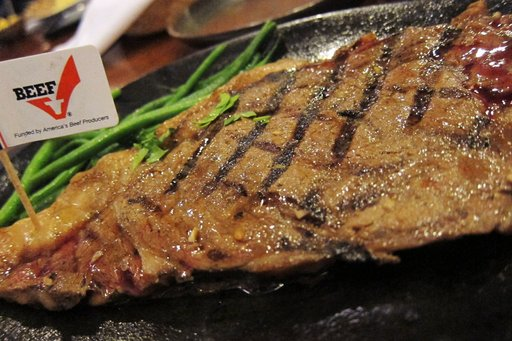

In [21]:
random_image_path = random.choice(image_path_list)

# get class name -> in path name
image_class = (
    random_image_path.parent.stem
)  # parent directory , stem-> without file extension

img = Image.open(random_image_path)

print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 340.5, -0.5)

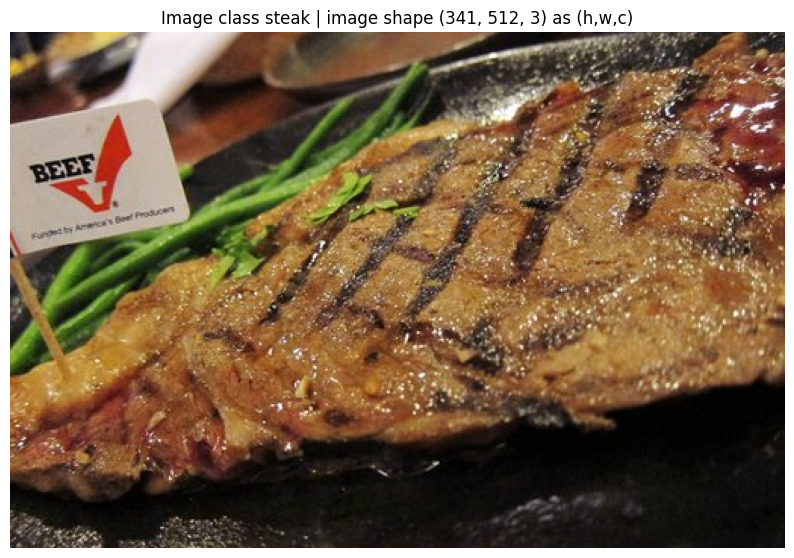

In [24]:
# visualise using matplotlib
import matplotlib.pyplot as plt 
import numpy as np 

# turn image into array
img_as_array = np.asarray(img)

# plot
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class {image_class} | image shape {img_as_array.shape} as (h,w,c)")
plt.axis(False)

In [26]:
img_as_array.shape

(341, 512, 3)

## transform data

- before training on image data turn into tensor 
- turn to torch.utils.data.Dataset 
- use orch.utils.data.DataLoader 

In [27]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### transform using torchvision.transforms

In [29]:
# using compose for multiple transforms
data_transform = transforms.Compose([
    # resize our images 
    transforms.Resize(size=(64,64)),
    # Flip images on horizontal 
    transforms.RandomHorizontalFlip(p=0.5),
    # turn image into torch.Tensor 
    transforms.ToTensor() # convert numpy(H,W,C) into torch.Tensor(C,H,W)
])


In [34]:
img.size# can convert PIL images too directly

(512, 341)

In [35]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

In [37]:
def plot_transformed_images(image_path, transform, n=3, seed=42):
    if seed:
        random.seed(seed)

    random_images = random.sample(image_path_list, k=n)
    for image_path in random_images:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_img = transform(f).permute(1,2,0) # change axis order to convert CHW -> HEC
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Original\nSize: {transformed_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

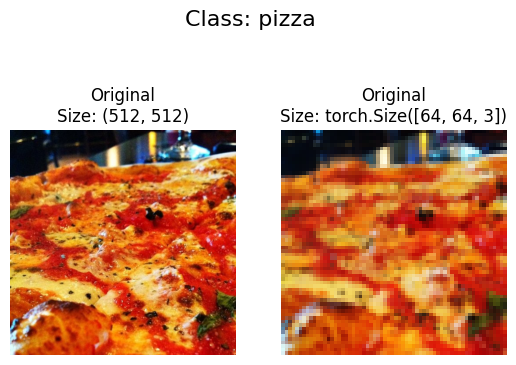

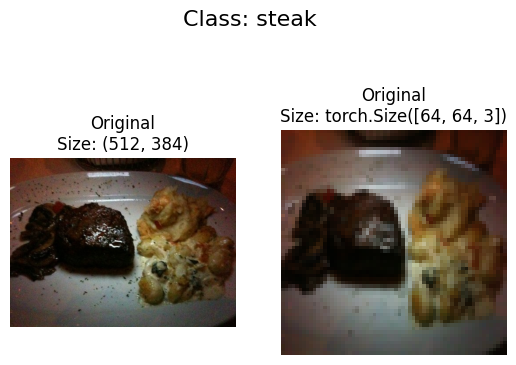

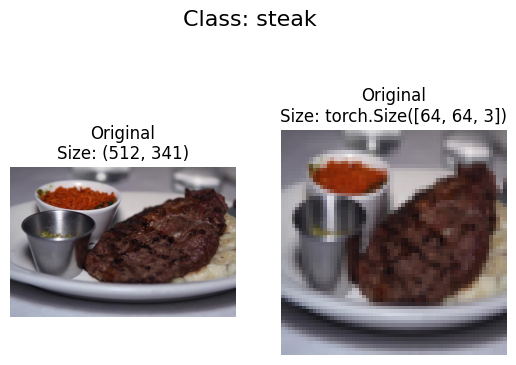

In [38]:
plot_transformed_images(image_path_list, data_transform, n=3)

# option 1 : loading image data using image folder

torchvision.datasets.ImageFolder

datasets have Base classes for custom datasets

DatasetFolder(root, loader[, extensions, ...]) A generic data loader.

ImageFolder(root, ~pathlib.Path], transform, ...) A generic data loader where the images are arranged in this way by default: .

VisionDataset([root, transforms, transform, ...]) Base Class For making datasets which are compatible with torchvision.

ImageFolder expects data to be like 

root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png

In [40]:
# use ImageFolder
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(
    root=test_dir, transform=data_transform, target_transform=None
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [54]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [55]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [56]:
train_data[0]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [57]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")
print(f"Image label: {label}")
print(f"Image label name: {class_names[label]}")
print(f"Image label dtype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image dtype: torch.float32
Image label: 0
Image label name: pizza
Image label dtype: <class 'int'>


(-0.5, 63.5, 63.5, -0.5)

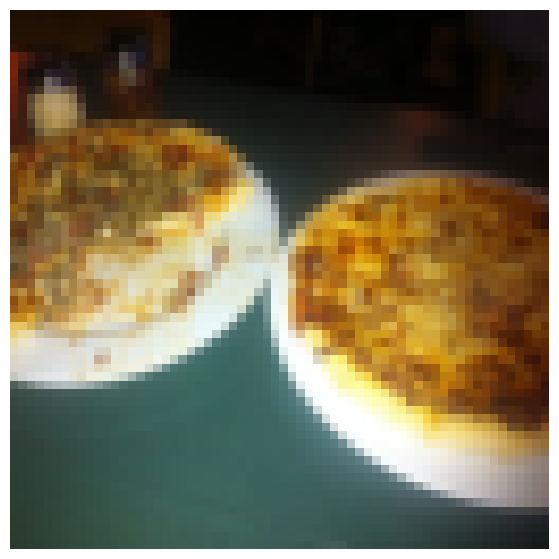

In [61]:
# plot using matplotlib
img_permute = img.permute(1,2,0)

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)

# turn dataset into dataloader

In [65]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(
    dataset=train_data, batch_size=batch_size, num_workers=1, shuffle=True
)
test_loader = DataLoader(
    dataset=test_data, batch_size=batch_size, num_workers=1, shuffle=True
)

In [69]:
len(train_loader), len(test_loader)

(8, 3)

In [71]:
img, label = next(iter(train_loader))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# option 2: Custom Datasets

In [72]:
import os 
import pathlib 
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [74]:
# helper functions
target_dir = train_dir 
print(f"Target directory: {target_dir}")

class_name_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_name_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [76]:
list(os.scandir(target_dir))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [77]:
# we want our function to return 
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [87]:
# expected output : (['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
    """Find class folder names in a target directory"""
    # 1. get the class names by scanning the directory
    classes = sorted([entry.name for entry in list(os.scandir(target_dir)) if entry.is_dir()])

    # 2. raise error if class name could not be found
    if not classes: 
        raise FileNotFoundError(f"Couldn't find any class in {directory}... check file structure")

    # 3. Create dictionary of index labels 
    #                - key: value - 
    class_to_idx = { class_name: i for i,class_name in enumerate(classes)}

    return classes, class_to_idx


In [88]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### create custom dataset

In [93]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir:str, transform:None):
        # Attributes
        # we pass either test or train: train/class/images.jpg
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        # create classes and class_to_idx
        self.classes, self.class_to_idx = self._find_classes(targ_dir)

    # we created this above
    def _find_classes(self, directory:str) -> Tuple[List[str], Dict[str,int]]:
        """Find class folder names in a target directory"""
        # 1. get the class names by scanning the directory
        classes = sorted(
            [entry.name for entry in list(os.scandir(directory)) if entry.is_dir()]
        )

        # 2. raise error if class name could not be found
        if not classes: 
            raise FileNotFoundError(f"Couldn't find any class in {directory}... check file structure")

        # 3. Create dictionary of index labels
        #                - key: value -
        class_to_idx = { class_name: i for i,class_name in enumerate(classes)}

        return classes, class_to_idx

    # Create function to load images
    def _load_image(self, index:int) -> Image.Image:
        """Opens via path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)

    # Overwrite len()
    def __len__(self) -> int:
        """Return total number of samples"""
        return len(self.paths)

    # Overwrite getitem(
    # replicates imge,label = train_data[0]
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """Return data and label of index"""
        img = self._load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [94]:
from torchvision import transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ]
)

# dont manipulate test
test_transforms = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
    ]
)

In [95]:
# test out custom dataset
train_custom_dataset = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_custom_dataset = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

train_custom_dataset, test_custom_dataset

(<__main__.ImageFolderCustom at 0x147c4d5e0>,
 <__main__.ImageFolderCustom at 0x147c4ddf0>)

In [96]:
len(train_custom_dataset), len(test_custom_dataset)

(225, 75)

In [99]:
train_custom_dataset.classes

['pizza', 'steak', 'sushi']

In [98]:
train_custom_dataset.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

## custom dataset to dataloader

In [101]:
from torch.utils.data import DataLoader

train_custom_dataloader = DataLoader(
    dataset=train_custom_dataset, batch_size=32, num_workers=1, shuffle=True
)
test_custom_dataloader = DataLoader(
    dataset=test_custom_dataset, batch_size=32, num_workers=1, shuffle=False
)

# Tinyvgg

### create transform and load data

In [102]:
from torchvision import transforms

simple_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
    ]
)

In [107]:
from torchvision import datasets
train_custom_dataset = ImageFolderCustom(targ_dir=train_dir, transform=simple_transform)
test_custom_dataset = ImageFolderCustom(targ_dir=test_dir, transform=simple_transform)

In [113]:
class_names = train_custom_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [136]:
from torch.utils.data import DataLoader

train_simple_dataloader = DataLoader(
    dataset=train_custom_dataset, batch_size=32, num_workers=0, shuffle=True
)
test_simple_dataloader = DataLoader(
    dataset=test_custom_dataset, batch_size=32, num_workers=0, shuffle=False
)

In [170]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel value
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel value
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x 

In [163]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'mps'

In [164]:
torch.manual_seed(42)

In [171]:
model0 = TinyVGG(3, 10, len(class_names)).to(device)

In [166]:
# dummy data to get shape for linear layer
image_batch, label_batch = next(iter(train_simple_dataloader))

In [167]:
image_batch.shape

torch.Size([32, 3, 64, 64])

In [ ]:
x = model0(image_batch.to(device))
# conv block 1: torch.Size([32, 10, 32, 32])
# conv block 2: torch.Size([32, 10, 16, 16])
# 10*16*16
# Result : torch.Size([32, 3])

torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])


## torchinfo

In [169]:
from torchinfo import summary 

summary(model0, input_size=[32,3,64,64])

torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

# create train and test step functions 

In [175]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [176]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device = device,
):
    model.eval()
    train_loss, train_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [189]:
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int = 5,
    device: torch.device = device,
):
    results = { 
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : [],
    }

    for epoch in tqdm(range(epochs)): 

        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(f"Epoch: {epoch} | train_loss: {train_loss} train_acc: {train_acc} | test_loss: {test_loss} test_acc: {test_acc}")

    return results

In [195]:
from timeit import default_timer as timer

In [197]:
torch.manual_seed(42)

epochs = 5
model0 = TinyVGG(3, 10, len(class_name)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.01)

start = timer()
# train 
model0_results = train(
    model=model0,
    train_dataloader=train_simple_dataloader,
    test_dataloader=test_simple_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device,
)
end = timer()
print(f"time it took to train model0: {end-start:3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.157447099685669 train_acc: 0.26171875 | test_loss: 1.1051963567733765 test_acc: 0.19791666666666666
Epoch: 1 | train_loss: 1.0978719890117645 train_acc: 0.29296875 | test_loss: 1.1045244534810383 test_acc: 0.3229166666666667
Epoch: 2 | train_loss: 1.09953173995018 train_acc: 0.28125 | test_loss: 1.1047306458155315 test_acc: 0.3229166666666667
Epoch: 3 | train_loss: 1.0964871793985367 train_acc: 0.40234375 | test_loss: 1.1067099173863728 test_acc: 0.3229166666666667
Epoch: 4 | train_loss: 1.1000743806362152 train_acc: 0.28125 | test_loss: 1.108263333638509 test_acc: 0.3229166666666667
time it took to train model0: 9.885254


## loss curve

In [198]:
model0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [205]:
def plot_loss_curve(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results["test_loss"]

    acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    # set up subplot
    plt.figure(figsize=(10,7))

    # plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

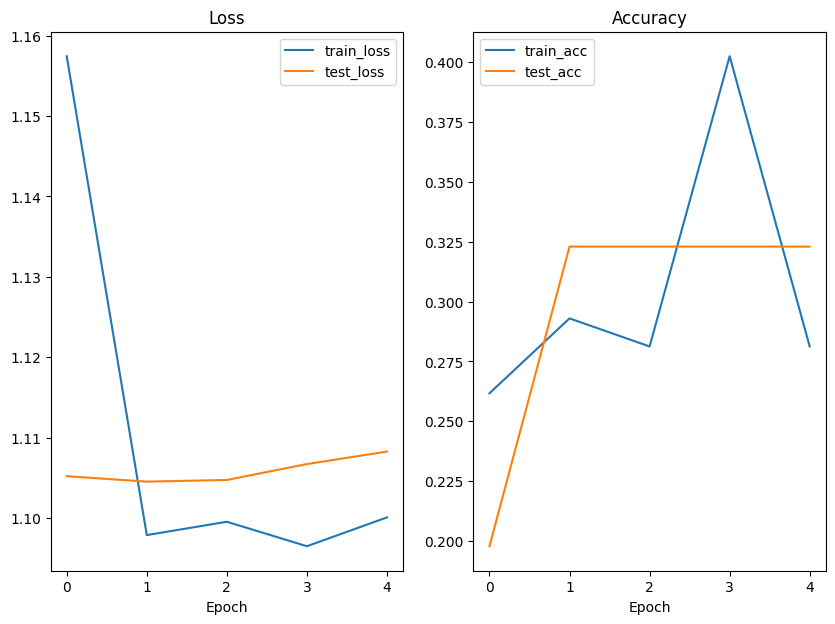

In [206]:
plot_loss_curve(model0_results)

# Model 2: augmentation

In [208]:
from torchvision import transforms

test_aug_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor(),
    ]
)

test_simple_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
    ]
)

In [213]:
from torchvision import datasets

train_aug_dataset = ImageFolderCustom(targ_dir=train_dir, transform=test_aug_transform)
test_simple_dataset = ImageFolderCustom(
    targ_dir=test_dir, transform=test_simple_transform
)

In [214]:
class_name = train_custom_dataset.classes
class_name

['pizza', 'steak', 'sushi']

In [215]:
from torch.utils.data import DataLoader

train_aug_dataloader = DataLoader(
    dataset=train_aug_dataset, batch_size=32, num_workers=0, shuffle=True
)
test_simple_dataloader = DataLoader(
    dataset=test_simple_dataset, batch_size=32, num_workers=0, shuffle=False
)

In [216]:
torch.manual_seed(42)

model1 = TinyVGG(3,10,len(class_name))
model1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### train

In [218]:
torch.manual_seed(42)

epochs = 5
model1 = TinyVGG(3, 10, len(class_name)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.01)

start = timer()
# train
model1_results = train(
    model=model1,
    train_dataloader=train_aug_dataloader,
    test_dataloader=test_simple_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device,
)
end = timer()
print(f"time it took to train model0: {end-start:3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.1001402586698532 train_acc: 0.265625 | test_loss: 1.0984333356221516 test_acc: 0.30776515151515155
Epoch: 1 | train_loss: 1.1003838926553726 train_acc: 0.25390625 | test_loss: 1.0984333356221516 test_acc: 0.30776515151515155
Epoch: 2 | train_loss: 1.10013847053051 train_acc: 0.25 | test_loss: 1.0984333356221516 test_acc: 0.30776515151515155
Epoch: 3 | train_loss: 1.0975745171308517 train_acc: 0.2578125 | test_loss: 1.0984333356221516 test_acc: 0.30776515151515155
Epoch: 4 | train_loss: 1.0978678166866302 train_acc: 0.2734375 | test_loss: 1.0984333356221516 test_acc: 0.30776515151515155
time it took to train model0: 7.358664


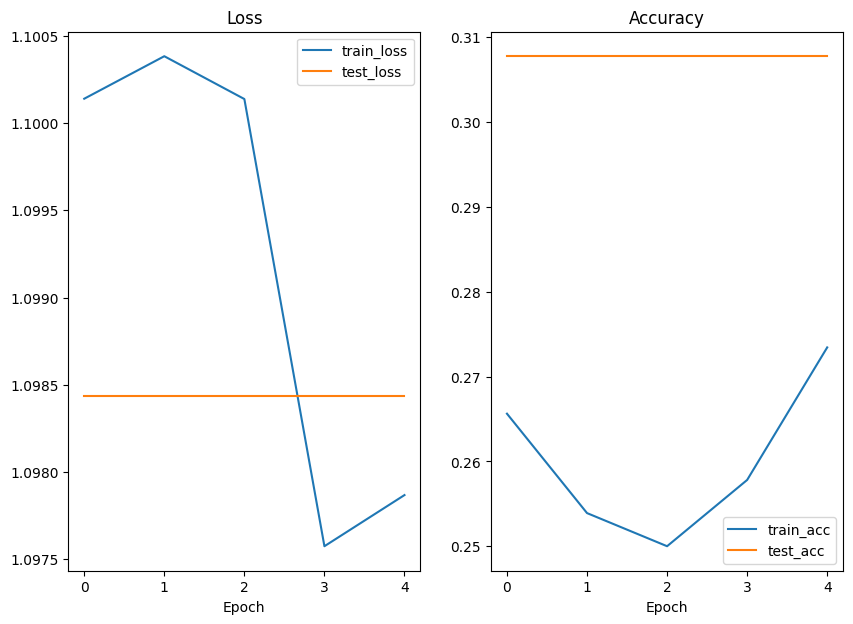

In [219]:
plot_loss_curve(model1_results)